In [16]:
import pandas as pd
import numpy as np

In [17]:
indicador = pd.read_csv('./files/Gross Domestic Product Annualized.csv')

USDMXN = pd.read_csv('./files/USDMXN.csv')

USDMXN_train = pd.read_csv('./files/USDMXN_train.csv')

USDMXN_test = pd.read_csv('./files/USDMXN_test.csv')

EURUSD = pd.read_csv('./files/EURUSD.csv')

EURUSD_train = pd.read_csv('./files/EURUSD_train.csv')

EURUSD_test = pd.read_csv('./files/EURUSD_test.csv')

In [18]:
print(len(USDMXN_train))
print(len(EURUSD_train))
print(len(USDMXN_test))
print(len(EURUSD_test))


24831
24897
25001
25021


In [19]:
capital_inicial = 100000
max_perdida_cap = 1000
capital_acumulado_ent = []
capital_actual = capital_inicial

min_length = min(len(USDMXN_train), len(EURUSD_train), len(USDMXN_test), len(EURUSD_test))

capital_acumulado_ent = []
capital_actual = capital_inicial

In [20]:
# Calcular de capital acumulado periodo entrenamiento
for i in range(min_length):
    precio_actual_USDMXN = USDMXN_train.iloc[i]['close']
    precio_anterior_USDMXN = USDMXN_train.iloc[i-1]['close']
    cambio_precio_USDMXN = precio_actual_USDMXN - precio_anterior_USDMXN

    precio_actual_EURUSD = EURUSD_train.iloc[i]['close']
    precio_anterior_EURUSDN = EURUSD_train.iloc[i-1]['close']
    cambio_precio_EURUSD = precio_actual_EURUSD - precio_anterior_EURUSDN

    # Calculo de capital actualizado
    cambio_capital = cambio_precio_USDMXN + cambio_precio_EURUSD
    capital_actual += cambio_capital

    # Ajuste si excede el limite de perdida max
    if cambio_capital < 0:
        capital_actual = max(capital_actual, capital_actual - max_perdida_cap)
    capital_acumulado_ent.append(capital_actual)

capital_acumulado_prueba = []
capital_actual = capital_inicial

In [21]:

# Calculo de capital acumulado periodo prueba
for i in range(min_length):
    precio_actual_USDMXN = USDMXN_test.iloc[i]['close']
    precio_anterior_USDMXN = USDMXN_test.iloc[i-1]['close']
    cambio_precio_USDMXN = precio_actual_USDMXN - precio_anterior_USDMXN

    precio_actual_EURUSD = EURUSD_test.iloc[i]['close']
    precio_anterior_EURUSDN = EURUSD_test.iloc[i-1]['close']
    cambio_precio_EURUSD = precio_actual_EURUSD - precio_anterior_EURUSDN

    # Calculo de capital actualizado
    cambio_capital = cambio_precio_USDMXN + cambio_precio_EURUSD
    capital_actual += cambio_capital

    # Ajuste si excede el limite de perdida max
    if cambio_capital < 0:
        capital_actual = max(capital_actual, capital_actual - max_perdida_cap)
    capital_acumulado_prueba.append(capital_actual)

# Calculo diferencias absolutas
dif_absolutas = abs(np.array(capital_acumulado_ent[:min_length]) - np.array(capital_acumulado_prueba[:min_length]))

# MAD 
mad1 = dif_absolutas.mean()
mad2 = np.median(dif_absolutas)
mad3 = np.mean(np.abs(dif_absolutas - np.mean(dif_absolutas)))
tabla = pd.DataFrame({'MAD1': [mad1], 'MAD2': [mad2], 'MAD3': [mad3]})
print(tabla)

       MAD1     MAD2      MAD3
0  2.150755  2.09363  1.298156


In [22]:
#def calcular_capital_acumulado(datos_precios):
import pandas as pd

def cal_rsi(data, window=14):
    delta = data.diff(1)
    delta.dropna(inplace=True)

    positive = delta.copy()
    negative = delta.copy()

    positive[positive < 0] = 0
    negative[negative > 0] = 0

    average_gain = positive.rolling(window=window).mean()
    average_loss = abs(negative.rolling(window=window).mean())

    relative_strength = average_gain / average_loss
    rsi = 100 - (100 / (1 + relative_strength))
    rsi = rsi.dropna()
    rsi = rsi.reset_index(drop=True)
    
    return rsi

In [23]:

# Define las variables y carga los datos

capital_inicial = 100000
max_perdida_cap = 1000
nivel_entrada = 30
nivel_salida = 70

rsi = cal_rsi(USDMXN_train['close'])  # Correr primero functions
indicador = pd.read_csv('./files/Gross Domestic Product Annualized.csv')  

min_length = min(len(USDMXN_train), len(EURUSD_train), len(USDMXN_test), len(EURUSD_test), len(indicador))
rsi = rsi[:min_length]
indicador = indicador[:min_length]

posicion_abierta = False
capital_actual = capital_inicial
cantidad_posicion = 0
precio_apertura = 0
precio_cierre = 0
capital_acumulado = []
operaciones = []
tickets = []  # Agrega una lista para almacenar los tickets

# Itera sobre los datos y realiza las operaciones
for i in range(len(rsi)):
    if rsi[i] > nivel_entrada and not posicion_abierta and indicador.iloc[i]['actual'] > 0:
        # Generar señal de compra
        precio_apertura = precio_actual_USDMXN  
        cantidad_posicion = (capital_actual * max_perdida_cap) / precio_apertura
        capital_actual -= cantidad_posicion * precio_apertura
        posicion_abierta = True
        operaciones.append('Compra')
        tickets.append(f'Compra Ticket {i+1}')
        capital_acumulado.append(capital_actual)

    elif rsi[i] < nivel_salida and posicion_abierta and indicador.iloc[i]['actual'] < 0:
        # Generar señal de venta
        precio_cierre = precio_actual_USDMXN  
        capital_actual += cantidad_posicion * precio_cierre
        posicion_abierta = False
        operaciones.append('Venta')
        tickets.append(f'Vende Ticket {i+1}')
        capital_acumulado.append(capital_actual)

    if posicion_abierta and (precio_cierre - precio_actual_USDMXN) < -max_perdida_cap:
        # Cierre de posición por pérdida máxima alcanzada
        capital_actual += cantidad_posicion * precio_actual_USDMXN
        posicion_abierta = False
        operaciones.append('Venta')
        tickets.append(f'Vende Ticket {i+1} (Max Loss)')
        capital_acumulado.append(capital_actual)

# Crear la tabla con los resultados
tabla_rsi = pd.DataFrame({'Operación': operaciones, 'Ticket': tickets})

In [24]:
# Crear la tabla con los resultados
tabla_rsi

,Operación,Ticket
0,Compra,Compra Ticket 1
1,Venta,Vende Ticket 55
2,Compra,Compra Ticket 63
3,Venta,Vende Ticket 67
4,Compra,Compra Ticket 69
5,Venta,Vende Ticket 124
6,Compra,Compra Ticket 138


# Hasta aqui es lo que tenemos bien (supuestamente)

## INTENTO CON RATIO DE SHARPE (SEGUN YO MAL)

2023-05-13 11:33:27,528 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████|100/100, best_cost=9.66
2023-05-13 11:33:28,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.660349623011502, best pos: [  4.98873166 296.49555074  62.14090805]


No se encontraron parámetros óptimos


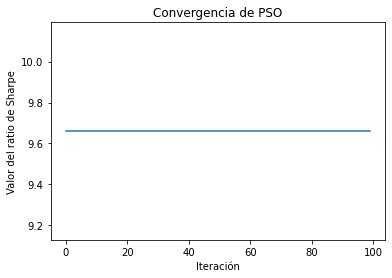

In [20]:
import pandas as pd
import numpy as np
import pyswarms as ps
import matplotlib.pyplot as plt

# Función para calcular el ratio de Sharpe
def calculate_sharpe_ratio(params):

    # Obtener los parámetros específicos que necesitas
    entrada, stop_loss, salida, *_ = params

    capital_inicial = 100000
    max_perdida_cap = stop_loss
    nivel_entrada = entrada
    nivel_salida = salida

    # Cálculo del ratio de Sharpe
    rendimiento = np.array(capital_acumulado_prueba) - capital_inicial
    rendimiento_diario = rendimiento / capital_inicial
    rendimiento_anualizado = rendimiento_diario.mean() * 252
    volatilidad_anualizada = rendimiento_diario.std() * np.sqrt(252)
    ratio_sharpe = rendimiento_anualizado / volatilidad_anualizada

    return -ratio_sharpe  # Se multiplica por -1 para convertirlo en un problema de maximización

# Definición de los límites de los parámetros
lower_bound = [1, 1, 31]
upper_bound = [30, 1000, 70]
bounds = (lower_bound, upper_bound)

# Configuración de PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Cantidad de partículas y dimensiones
n_particles = 50
dimensions = 3

# Optimización con PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)
best_params, best_value = optimizer.optimize(calculate_sharpe_ratio, iters=100)

if isinstance(best_params, float):
    print("No se encontraron parámetros óptimos")
else:
    print('Mejores parámetros encontrados:')
    print('Entrada:', best_params[0])
    print('Stop Loss:', best_params[1])
    print('Salida:', best_params[2])


# Gráfica de convergencia
plt.plot(optimizer.cost_history)
plt.xlabel('Iteración')
plt.ylabel('Valor del ratio de Sharpe')
plt.title('Convergencia de PSO')
plt.show()


2023-05-13 11:39:19,099 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████|100/100, best_cost=-23.8
2023-05-13 11:39:21,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -23.81176179958131, best pos: [ 22.40559346 519.55229309  63.93539434]


No se encontraron parámetros óptimos


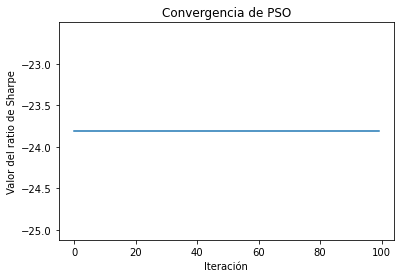

In [24]:
import numpy as np
import pyswarms as ps
import matplotlib.pyplot as plt

# Datos de ejemplo para probar el cálculo del ratio de Sharpe
capital_acumulado_prueba = [100000, 105000, 110000, 120000, 115000, 125000, 130000]

# Función para calcular el ratio de Sharpe
def calculate_sharpe_ratio(params):
    entrada, stop_loss, salida, *_ = params

    capital_inicial = 100000
    max_perdida_cap = stop_loss
    nivel_entrada = entrada
    nivel_salida = salida

    # Cálculo del ratio de Sharpe
    rendimiento = np.array(capital_acumulado_prueba) - capital_inicial
    rendimiento_diario = rendimiento / capital_inicial
    rendimiento_anualizado = rendimiento_diario.mean() * 252
    volatilidad_anualizada = rendimiento_diario.std() * np.sqrt(252)
    ratio_sharpe = rendimiento_anualizado / volatilidad_anualizada

    return -ratio_sharpe  # Se multiplica por -1 para convertirlo en un problema de maximización

# Definición de los límites de los parámetros
lower_bound = [1, 1, 31]
upper_bound = [30, 1000, 70]
bounds = (lower_bound, upper_bound)

# Configuración de PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Cantidad de partículas y dimensiones
n_particles = 10000
dimensions = 3

# Optimización con PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)
best_params, best_value = optimizer.optimize(calculate_sharpe_ratio, iters=100)

if isinstance(best_params, float):
    print("No se encontraron parámetros óptimos")
else:
    print('Mejores parámetros encontrados:')
    print('Entrada:', best_params[0])
    print('Stop Loss:', best_params[1])
    print('Salida:', best_params[2])

# Gráfica de convergencia
plt.plot(optimizer.cost_history)
plt.xlabel('Iteración')
plt.ylabel('Valor del ratio de Sharpe')
plt.title('Convergencia de PSO')
plt.show()



# ACA ES CON ALGORITMOS GENETICOS UTILIZANDO LOS 3 PARAMETROS

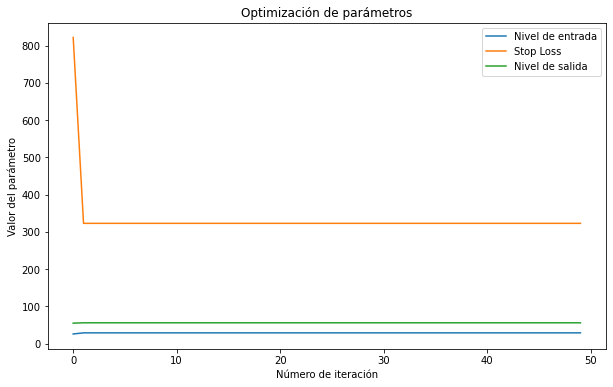

In [26]:
def evaluar_parametros(parametros):
    nivel_entrada, stop_loss, nivel_salida = parametros

    # Inicializar variables y listas para el cálculo del rendimiento
    posicion_abierta = False
    capital_actual = capital_inicial
    cantidad_posicion = 0
    precio_apertura = 0
    precio_cierre = 0
    capital_acumulado = []

    # Obtener el número mínimo de elementos en los datos históricos
    min_length = min(len(USDMXN_train), len(EURUSD_train), len(rsi), len(indicador), len(capital_acumulado_prueba))

    # Iterar sobre los datos históricos y realizar las operaciones
    for i in range(min_length):
        # Obtener los precios y datos relevantes para el cálculo
        precio_actual_USDMXN = USDMXN_train.iloc[i]['close']
        precio_anterior_USDMXN = USDMXN_train.iloc[i-1]['close']
        cambio_precio_USDMXN = precio_actual_USDMXN - precio_anterior_USDMXN

        precio_actual_EURUSD = EURUSD_train.iloc[i]['close']
        precio_anterior_EURUSDN = EURUSD_train.iloc[i-1]['close']
        cambio_precio_EURUSD = precio_actual_EURUSD - precio_anterior_EURUSDN


        # Realizar la lógica de entrada y salida basada en los parámetros
        if rsi[i] > nivel_entrada and not posicion_abierta and indicador.iloc[i]['actual'] > 0:
            # Generar señal de compra
            precio_apertura = precio_actual_USDMXN  
            cantidad_posicion = (capital_actual * max_perdida_cap) / precio_apertura
            capital_actual -= cantidad_posicion * precio_apertura
            posicion_abierta = True
        elif rsi[i] < nivel_salida and posicion_abierta and indicador.iloc[i]['actual'] < 0:
            # Generar señal de venta
            precio_cierre = precio_actual_USDMXN  
            capital_actual += cantidad_posicion * precio_cierre
            posicion_abierta = False

        # Verificar si se alcanzó la pérdida máxima permitida
        if posicion_abierta and (precio_cierre - precio_actual_USDMXN) < -max_perdida_cap:
            # Cierre de posición por pérdida máxima alcanzada
            capital_actual += cantidad_posicion * precio_actual_USDMXN
            posicion_abierta = False

        # Agregar el capital acumulado a la lista
        capital_acumulado.append(capital_actual)

    # Calcular la diferencia absoluta entre el capital acumulado en el período de entrenamiento y prueba
    dif_absolutas = abs(np.array(capital_acumulado) - np.array(capital_acumulado_prueba[:min_length]))

    # Calcular la métrica de rendimiento (por ejemplo, MAD)
    rendimiento = dif_absolutas.mean()

    return rendimiento

# Parámetros del algoritmo genético
tamaño_poblacion = 20
num_generaciones = 50
probabilidad_cruce = 0.8
probabilidad_mutacion = 0.2

# Rango de valores para cada parámetro
rango_entrada = (1, 30)
rango_stop_loss = (1, 1000)
rango_salida = (31, 70)

# Espacio de búsqueda total
espacio_busqueda = (rango_entrada[1] - rango_entrada[0] + 1) * (rango_stop_loss[1] - rango_stop_loss[0] + 1) * (rango_salida[1] - rango_salida[0] + 1)

# Generación aleatoria de la población inicial
poblacion = []
for _ in range(tamaño_poblacion):
    entrada = random.randint(rango_entrada[0], rango_entrada[1])
    stop_loss = random.randint(rango_stop_loss[0], rango_stop_loss[1])
    salida = random.randint(rango_salida[0], rango_salida[1])
    individuo = [entrada, stop_loss, salida]
    poblacion.append(individuo)

# Algoritmo genético
mejor_fitness = float('inf')
mejores_parametros = None
mejor_fitness_historico = []
mejor_entrada_historico = []
mejor_stop_loss_historico = []
mejor_salida_historico = []

for generacion in range(num_generaciones):
    # Evaluación de la población actual
    fitness_poblacion = [evaluar_parametros(individuo) for individuo in poblacion]

    # Actualización del mejor individuo y su fitness
    mejor_individuo_idx = np.argmin(fitness_poblacion)
    mejor_fitness_actual = fitness_poblacion[mejor_individuo_idx]
    mejor_individuo_actual = poblacion[mejor_individuo_idx]

    # Verificación si se encontró un nuevo mejor individuo
    if mejor_fitness_actual < mejor_fitness:
        mejor_fitness = mejor_fitness_actual
        mejores_parametros = mejor_individuo_actual

    # Almacenar los resultados de la mejor configuración en cada generación
    mejor_fitness_historico.append(mejor_fitness)
    mejor_entrada_historico.append(mejores_parametros[0])
    mejor_stop_loss_historico.append(mejores_parametros[1])
    mejor_salida_historico.append(mejores_parametros[2])

    # Selección de padres mediante torneo binario
    padres = []
    for _ in range(tamaño_poblacion):
        padre1 = random.choice(poblacion)
        padre2 = random.choice(poblacion)
        if fitness_poblacion[poblacion.index(padre1)] < fitness_poblacion[poblacion.index(padre2)]:
            padres.append(padre1)
        else:
            padres.append(padre2)

    # Creación de la nueva generación mediante cruces y mutaciones
    nueva_generacion = []
    for _ in range(tamaño_poblacion):
        padre1 = random.choice(padres)
        padre2 = random.choice(padres)

        # Operador de cruce: punto de cruce aleatorio
        punto_cruce = random.randint(1, 2)
        hijo = padre1[:punto_cruce] + padre2[punto_cruce:]

        # Operador de mutación: mutación aleatoria en un gen
        if random.random() < probabilidad_mutacion:
            gen_mutado = random.randint(0, 2)
             
            if gen_mutado == 0:
                hijo[gen_mutado] = random.randint(rango_entrada[0], rango_entrada[1])
            elif gen_mutado == 1:
                hijo[gen_mutado] = random.randint(rango_stop_loss[0], rango_stop_loss[1])
            else:
                hijo[gen_mutado] = random.randint(rango_salida[0], rango_salida[1])

        nueva_generacion.append(hijo)

    # Reemplazo de la población anterior con la nueva generación
    poblacion = nueva_generacion

# Impresión de los mejores parámetros encontrados


# Gráfica de los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(num_generaciones), mejor_entrada_historico, label='Nivel de entrada')
plt.plot(range(num_generaciones), mejor_stop_loss_historico, label='Stop Loss')
plt.plot(range(num_generaciones), mejor_salida_historico, label='Nivel de salida')
plt.xlabel('Número de iteración')
plt.ylabel('Valor del parámetro')
plt.title('Optimización de parámetros')
plt.legend()
plt.show()